In [28]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [29]:
# Create Tensors to hold input and outputs.

beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=[1,2,3,4,5,11,12,13,14,15]


def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [30]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


tensor(0.2283, dtype=torch.float64)

tensor(0.2145, dtype=torch.float64)

tensor(0.2181, dtype=torch.float64)

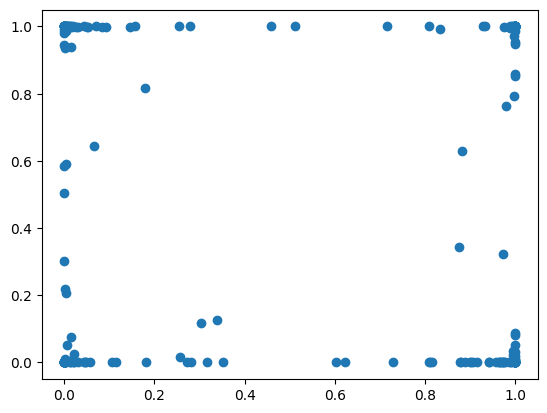

In [31]:
plt.scatter(sigmoid(x2@beta_2).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()

In [32]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [33]:
################## first step##################

# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2 = config["lambda1"], config["lambda2"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.8
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)
            non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.005,0.01,0.02,0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002])
    }
    #config={
    #    "lambda1": tune.choice([0.05,0.1,0.6]),
    #    "lambda2": tune.choice([0.0001,0.0002,0.0003, 0.0004,0.0005])
    #}

    result = tune.run(
        train_model,  
        config=config,
        num_samples=50)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,lambda1,lambda2,iter,total time (s),my_test_BCE_loss
train_model_47a26_00000,TERMINATED,10.224.0.12:7463,0.03,0.002,1,12.8293,1.42508
train_model_47a26_00001,TERMINATED,10.224.0.12:7847,0.04,0.002,1,13.3084,1.42761
train_model_47a26_00002,TERMINATED,10.224.0.12:7848,0.005,0.002,1,12.9748,1.76668
train_model_47a26_00003,TERMINATED,10.224.0.12:7850,0.005,0.002,1,14.4556,1.76668
train_model_47a26_00004,TERMINATED,10.224.0.12:7852,0.03,0.002,1,14.4359,1.42508
train_model_47a26_00005,TERMINATED,10.224.0.12:7853,0.02,0.001,1,13.3634,1.63843
train_model_47a26_00006,TERMINATED,10.224.0.12:7854,0.01,0.002,1,13.8743,1.61472
train_model_47a26_00007,TERMINATED,10.224.0.12:7856,0.005,0.001,1,13.9606,1.9657
train_model_47a26_00008,TERMINATED,10.224.0.12:7858,0.03,0.001,1,12.4486,1.55665
train_model_47a26_00009,TERMINATED,10.224.0.12:7860,0.02,0.002,1,12.8911,1.51381


Result for train_model_47a26_00000:
  date: 2022-10-12_19-02-08
  done: false
  experiment_id: 2ccda0264dfd46779690a75a5eb5b432
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.425084161758423
  node_ip: 10.224.0.12
  pid: 7463
  time_since_restore: 12.829317569732666
  time_this_iter_s: 12.829317569732666
  time_total_s: 12.829317569732666
  timestamp: 1665572528
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 47a26_00000
  warmup_time: 0.0035064220428466797
  
Result for train_model_47a26_00000:
  date: 2022-10-12_19-02-08
  done: true
  experiment_id: 2ccda0264dfd46779690a75a5eb5b432
  experiment_tag: 0_lambda1=0.0300,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.425084161758423
  node_ip: 10.224.0.12
  pid: 7463
  time_since_restore: 12.829317569732666
  time_this_iter_s: 12.829317569732666
  time_total_s: 12.829317569732666
  timestamp: 1665572528
  timesteps_since_restore: 0
 

Result for train_model_47a26_00028:
  date: 2022-10-12_19-02-13
  done: false
  experiment_id: fe64119e757b49b4bef35fdb45620f7f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5566548228263855
  node_ip: 10.224.0.12
  pid: 7898
  time_since_restore: 12.995512962341309
  time_this_iter_s: 12.995512962341309
  time_total_s: 12.995512962341309
  timestamp: 1665572533
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 47a26_00028
  warmup_time: 0.007224559783935547
  
Result for train_model_47a26_00028:
  date: 2022-10-12_19-02-13
  done: true
  experiment_id: fe64119e757b49b4bef35fdb45620f7f
  experiment_tag: 28_lambda1=0.0300,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5566548228263855
  node_ip: 10.224.0.12
  pid: 7898
  time_since_restore: 12.995512962341309
  time_this_iter_s: 12.995512962341309
  time_total_s: 12.995512962341309
  timestamp: 1665572533
  timesteps_since_restore: 0

Result for train_model_47a26_00027:
  date: 2022-10-12_19-02-13
  done: false
  experiment_id: 2b59bb989f6e465b892b57b6c36a6ef3
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7630043268203734
  node_ip: 10.224.0.12
  pid: 7896
  time_since_restore: 13.59853744506836
  time_this_iter_s: 13.59853744506836
  time_total_s: 13.59853744506836
  timestamp: 1665572533
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 47a26_00027
  warmup_time: 0.013054132461547852
  
Result for train_model_47a26_00027:
  date: 2022-10-12_19-02-13
  done: true
  experiment_id: 2b59bb989f6e465b892b57b6c36a6ef3
  experiment_tag: 27_lambda1=0.0100,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7630043268203734
  node_ip: 10.224.0.12
  pid: 7896
  time_since_restore: 13.59853744506836
  time_this_iter_s: 13.59853744506836
  time_total_s: 13.59853744506836
  timestamp: 1665572533
  timesteps_since_restore: 0
  tra

Result for train_model_47a26_00031:
  date: 2022-10-12_19-02-14
  done: false
  experiment_id: bda80751de5a4165ab7b6797518a8da8
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5719324111938477
  node_ip: 10.224.0.12
  pid: 7904
  time_since_restore: 14.107130527496338
  time_this_iter_s: 14.107130527496338
  time_total_s: 14.107130527496338
  timestamp: 1665572534
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 47a26_00031
  warmup_time: 0.0060024261474609375
  
Result for train_model_47a26_00031:
  date: 2022-10-12_19-02-14
  done: true
  experiment_id: bda80751de5a4165ab7b6797518a8da8
  experiment_tag: 31_lambda1=0.0500,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5719324111938477
  node_ip: 10.224.0.12
  pid: 7904
  time_since_restore: 14.107130527496338
  time_this_iter_s: 14.107130527496338
  time_total_s: 14.107130527496338
  timestamp: 1665572534
  timesteps_since_restore: 

Result for train_model_47a26_00034:
  date: 2022-10-12_19-02-21
  done: false
  experiment_id: c69524e8a5e742e89b0033f043bffa10
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9657042026519775
  node_ip: 10.224.0.12
  pid: 7860
  time_since_restore: 9.231438636779785
  time_this_iter_s: 9.231438636779785
  time_total_s: 9.231438636779785
  timestamp: 1665572541
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 47a26_00034
  warmup_time: 0.009790182113647461
  
Result for train_model_47a26_00034:
  date: 2022-10-12_19-02-21
  done: true
  experiment_id: c69524e8a5e742e89b0033f043bffa10
  experiment_tag: 34_lambda1=0.0050,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9657042026519775
  node_ip: 10.224.0.12
  pid: 7860
  time_since_restore: 9.231438636779785
  time_this_iter_s: 9.231438636779785
  time_total_s: 9.231438636779785
  timestamp: 1665572541
  timesteps_since_restore: 0
  tra

Result for train_model_47a26_00037:
  date: 2022-10-12_19-02-22
  done: false
  experiment_id: cce26c31120a498a9340299d7f8565d8
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5719324111938477
  node_ip: 10.224.0.12
  pid: 7864
  time_since_restore: 10.121857643127441
  time_this_iter_s: 10.121857643127441
  time_total_s: 10.121857643127441
  timestamp: 1665572542
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 47a26_00037
  warmup_time: 0.0060427188873291016
  
Result for train_model_47a26_00037:
  date: 2022-10-12_19-02-22
  done: true
  experiment_id: cce26c31120a498a9340299d7f8565d8
  experiment_tag: 37_lambda1=0.0500,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5719324111938477
  node_ip: 10.224.0.12
  pid: 7864
  time_since_restore: 10.121857643127441
  time_this_iter_s: 10.121857643127441
  time_total_s: 10.121857643127441
  timestamp: 1665572542
  timesteps_since_restore: 

2022-10-12 19:02:24,819	INFO tune.py:758 -- Total run time: 31.36 seconds (31.06 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
47a26_00000          1.425084         12.829318  True            None   
47a26_00001          1.427609         13.308433  True            None   
47a26_00002          1.766684         12.974794  True            None   
47a26_00003          1.766684         14.455642  True            None   
47a26_00004          1.425084         14.435892  True            None   
47a26_00005          1.638432         13.363377  True            None   
47a26_00006          1.614721         13.874312  True            None   
47a26_00007          1.965704         13.960584  True            None   
47a26_00008          1.556655         12.448563  True            None   
47a26_00009          1.513810         12.891086  True            None   
47a26_00010          1.556655         14.496291  True            N

In [34]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.425084161758423


{'lambda1': 0.03, 'lambda2': 0.002}

In [35]:
################## second step##################

#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2=final_lambda["lambda1"],final_lambda["lambda2"]
learning_rate=0.8
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.1337, grad_fn=<AddBackward0>)

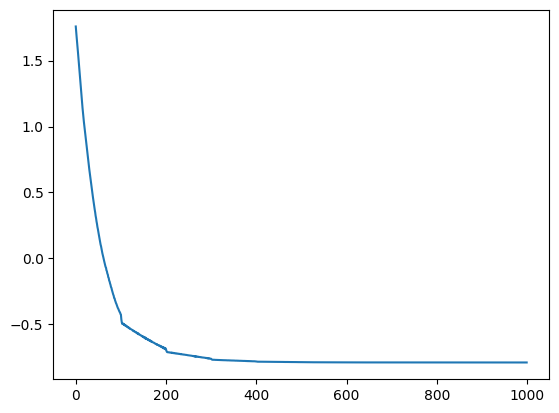

In [36]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [37]:
################## Y_prior##################
y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x2)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(2.3332)

tensor(0.0635)

tensor(0.0112)

tensor(2.2586)

In [38]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[90,  0],
       [ 0, 70]])

array([[88,  0],
       [ 0, 72]])

array([[68,  1],
       [ 0, 91]])

In [39]:
################## third step##################

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=10
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta = config["lambda1"], config["lambda2"],config["eta"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.8
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
#         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, targets_1[idx_test].reshape(-1,1))

        test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
    }

#      "eta": tune.choice([0.06,0.07,0.08,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.9]

    result = tune.run(
        train_model,  
        config=config,
        num_samples=100)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,iter,total time (s),my_test_BCE_loss
train_model_74e4f_00000,TERMINATED,10.224.0.12:9378,0.12,0.01,0.002,1,29.6113,1.73885
train_model_74e4f_00001,TERMINATED,10.224.0.12:9798,0.12,0.01,0.002,1,31.7823,1.73885
train_model_74e4f_00002,TERMINATED,10.224.0.12:9800,0.75,0.03,0.003,1,30.715,1.48518
train_model_74e4f_00003,TERMINATED,10.224.0.12:9802,0.65,0.01,0.002,1,29.2445,1.76164
train_model_74e4f_00004,TERMINATED,10.224.0.12:9804,0.06,0.05,0.003,1,31.6762,1.07355
train_model_74e4f_00005,TERMINATED,10.224.0.12:9806,0.75,0.05,0.003,1,30.8448,1.44937
train_model_74e4f_00006,TERMINATED,10.224.0.12:9808,0.75,0.03,0.001,1,31.3672,1.54209
train_model_74e4f_00007,TERMINATED,10.224.0.12:9810,0.25,0.03,0.001,1,31.6763,1.39214
train_model_74e4f_00008,TERMINATED,10.224.0.12:9812,0.45,0.01,0.001,1,31.7641,1.80117
train_model_74e4f_00009,TERMINATED,10.224.0.12:9814,0.09,0.03,0.002,1,30.5139,1.39001


Result for train_model_74e4f_00000:
  date: 2022-10-12_19-03-41
  done: false
  experiment_id: 7a92c69e41784d29a57f19e056e70eb9
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7388468384742737
  node_ip: 10.224.0.12
  pid: 9378
  time_since_restore: 29.611337900161743
  time_this_iter_s: 29.611337900161743
  time_total_s: 29.611337900161743
  timestamp: 1665572621
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00000
  warmup_time: 0.003967761993408203
  
Result for train_model_74e4f_00000:
  date: 2022-10-12_19-03-41
  done: true
  experiment_id: 7a92c69e41784d29a57f19e056e70eb9
  experiment_tag: 0_eta=0.1200,lambda1=0.0100,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7388468384742737
  node_ip: 10.224.0.12
  pid: 9378
  time_since_restore: 29.611337900161743
  time_this_iter_s: 29.611337900161743
  time_total_s: 29.611337900161743
  timestamp: 1665572621
  timesteps_since_

Result for train_model_74e4f_00015:
  date: 2022-10-12_19-03-46
  done: true
  experiment_id: 1116fa9c78144045b05d11dd8037e108
  experiment_tag: 15_eta=0.6500,lambda1=0.0200,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7029165983200074
  node_ip: 10.224.0.12
  pid: 9826
  time_since_restore: 30.550567150115967
  time_this_iter_s: 30.550567150115967
  time_total_s: 30.550567150115967
  timestamp: 1665572626
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00015
  warmup_time: 0.011988401412963867
  
Result for train_model_74e4f_00030:
  date: 2022-10-12_19-03-46
  done: false
  experiment_id: d783bcfd05d1465fb1b42e3aee5fe970
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5280973196029664
  node_ip: 10.224.0.12
  pid: 9857
  time_since_restore: 30.06607937812805
  time_this_iter_s: 30.06607937812805
  time_total_s: 30.06607937812805
  timestamp: 1665572626
  timesteps_since_re

Result for train_model_74e4f_00026:
  date: 2022-10-12_19-03-46
  done: false
  experiment_id: 146bdf453dcc4329b47c965db18dff36
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4678320050239564
  node_ip: 10.224.0.12
  pid: 9849
  time_since_restore: 30.438185691833496
  time_this_iter_s: 30.438185691833496
  time_total_s: 30.438185691833496
  timestamp: 1665572626
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00026
  warmup_time: 0.005829334259033203
  
Result for train_model_74e4f_00026:
  date: 2022-10-12_19-03-46
  done: true
  experiment_id: 146bdf453dcc4329b47c965db18dff36
  experiment_tag: 26_eta=0.7500,lambda1=0.0500,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4678320050239564
  node_ip: 10.224.0.12
  pid: 9849
  time_since_restore: 30.438185691833496
  time_this_iter_s: 30.438185691833496
  time_total_s: 30.438185691833496
  timestamp: 1665572626
  timesteps_since

Result for train_model_74e4f_00027:
  date: 2022-10-12_19-03-47
  done: false
  experiment_id: 42933e1c8fb04f88bf932bbded03b000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.140293288230896
  node_ip: 10.224.0.12
  pid: 9851
  time_since_restore: 31.645698070526123
  time_this_iter_s: 31.645698070526123
  time_total_s: 31.645698070526123
  timestamp: 1665572627
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00027
  warmup_time: 0.018813610076904297
  
Result for train_model_74e4f_00008:
  date: 2022-10-12_19-03-47
  done: false
  experiment_id: a49899ff8d654e839b01d0e16c6516d6
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8011690020561217
  node_ip: 10.224.0.12
  pid: 9812
  time_since_restore: 31.764123916625977
  time_this_iter_s: 31.764123916625977
  time_total_s: 31.764123916625977
  timestamp: 1665572627
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00008
  

Result for train_model_74e4f_00043:
  date: 2022-10-12_19-04-15
  done: false
  experiment_id: e92b437070124bac918421b79bb704d5
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2195879161357879
  node_ip: 10.224.0.12
  pid: 9831
  time_since_restore: 29.28309988975525
  time_this_iter_s: 29.28309988975525
  time_total_s: 29.28309988975525
  timestamp: 1665572655
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00043
  warmup_time: 0.0052258968353271484
  
Result for train_model_74e4f_00043:
  date: 2022-10-12_19-04-15
  done: true
  experiment_id: e92b437070124bac918421b79bb704d5
  experiment_tag: 43_eta=0.2500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2195879161357879
  node_ip: 10.224.0.12
  pid: 9831
  time_since_restore: 29.28309988975525
  time_this_iter_s: 29.28309988975525
  time_total_s: 29.28309988975525
  timestamp: 1665572655
  timesteps_since_rest

Result for train_model_74e4f_00042:
  date: 2022-10-12_19-04-16
  done: false
  experiment_id: d783bcfd05d1465fb1b42e3aee5fe970
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.1850308775901794
  node_ip: 10.224.0.12
  pid: 9857
  time_since_restore: 30.018566608428955
  time_this_iter_s: 30.018566608428955
  time_total_s: 30.018566608428955
  timestamp: 1665572656
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00042
  warmup_time: 0.004542827606201172
  
Result for train_model_74e4f_00042:
  date: 2022-10-12_19-04-16
  done: true
  experiment_id: d783bcfd05d1465fb1b42e3aee5fe970
  experiment_tag: 42_eta=0.9500,lambda1=0.0100,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.1850308775901794
  node_ip: 10.224.0.12
  pid: 9857
  time_since_restore: 30.018566608428955
  time_this_iter_s: 30.018566608428955
  time_total_s: 30.018566608428955
  timestamp: 1665572656
  timesteps_since

Result for train_model_74e4f_00040:
  date: 2022-10-12_19-04-17
  done: false
  experiment_id: dafccb59769c4543a9d521123222b21d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9465664982795716
  node_ip: 10.224.0.12
  pid: 9843
  time_since_restore: 31.447490692138672
  time_this_iter_s: 31.447490692138672
  time_total_s: 31.447490692138672
  timestamp: 1665572657
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00040
  warmup_time: 0.007558345794677734
  
Result for train_model_74e4f_00040:
  date: 2022-10-12_19-04-17
  done: true
  experiment_id: dafccb59769c4543a9d521123222b21d
  experiment_tag: 40_eta=0.0900,lambda1=0.0100,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9465664982795716
  node_ip: 10.224.0.12
  pid: 9843
  time_since_restore: 31.447490692138672
  time_this_iter_s: 31.447490692138672
  time_total_s: 31.447490692138672
  timestamp: 1665572657
  timesteps_since

Result for train_model_74e4f_00057:
  date: 2022-10-12_19-04-18
  done: true
  experiment_id: dfba8a05c7c4406d91cca2fda9e5a1eb
  experiment_tag: 57_eta=0.0900,lambda1=0.0300,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3116484761238099
  node_ip: 10.224.0.12
  pid: 9804
  time_since_restore: 31.290201425552368
  time_this_iter_s: 31.290201425552368
  time_total_s: 31.290201425552368
  timestamp: 1665572658
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00057
  warmup_time: 0.01839756965637207
  
Result for train_model_74e4f_00054:
  date: 2022-10-12_19-04-19
  done: false
  experiment_id: 7a7aeaf402cd4e26bac192a43366c46d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2192804157733916
  node_ip: 10.224.0.12
  pid: 9828
  time_since_restore: 31.7413387298584
  time_this_iter_s: 31.7413387298584
  time_total_s: 31.7413387298584
  timestamp: 1665572659
  timesteps_since_restor

Result for train_model_74e4f_00072:
  date: 2022-10-12_19-04-46
  done: false
  experiment_id: 306103ed2fd54405b4d65dc497691cb3
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.054552435874939
  node_ip: 10.224.0.12
  pid: 9800
  time_since_restore: 30.115586280822754
  time_this_iter_s: 30.115586280822754
  time_total_s: 30.115586280822754
  timestamp: 1665572686
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00072
  warmup_time: 0.009388208389282227
  
Result for train_model_74e4f_00072:
  date: 2022-10-12_19-04-46
  done: true
  experiment_id: 306103ed2fd54405b4d65dc497691cb3
  experiment_tag: 72_eta=0.9500,lambda1=0.0200,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.054552435874939
  node_ip: 10.224.0.12
  pid: 9800
  time_since_restore: 30.115586280822754
  time_this_iter_s: 30.115586280822754
  time_total_s: 30.115586280822754
  timestamp: 1665572686
  timesteps_since_r

Result for train_model_74e4f_00078:
  date: 2022-10-12_19-04-47
  done: false
  experiment_id: 2629b899464c4e3aa2f8922a20d81421
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7452537059783935
  node_ip: 10.224.0.12
  pid: 9806
  time_since_restore: 30.269371509552002
  time_this_iter_s: 30.269371509552002
  time_total_s: 30.269371509552002
  timestamp: 1665572687
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00078
  warmup_time: 0.0038776397705078125
  
Result for train_model_74e4f_00078:
  date: 2022-10-12_19-04-47
  done: true
  experiment_id: 2629b899464c4e3aa2f8922a20d81421
  experiment_tag: 78_eta=0.9500,lambda1=0.0400,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7452537059783935
  node_ip: 10.224.0.12
  pid: 9806
  time_since_restore: 30.269371509552002
  time_this_iter_s: 30.269371509552002
  time_total_s: 30.269371509552002
  timestamp: 1665572687
  timesteps_sinc

Result for train_model_74e4f_00081:
  date: 2022-10-12_19-04-48
  done: false
  experiment_id: 146bdf453dcc4329b47c965db18dff36
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4596364855766297
  node_ip: 10.224.0.12
  pid: 9849
  time_since_restore: 31.17185926437378
  time_this_iter_s: 31.17185926437378
  time_total_s: 31.17185926437378
  timestamp: 1665572688
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00081
  warmup_time: 0.005829334259033203
  
Result for train_model_74e4f_00081:
  date: 2022-10-12_19-04-48
  done: true
  experiment_id: 146bdf453dcc4329b47c965db18dff36
  experiment_tag: 81_eta=0.6500,lambda1=0.0500,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4596364855766297
  node_ip: 10.224.0.12
  pid: 9849
  time_since_restore: 31.17185926437378
  time_this_iter_s: 31.17185926437378
  time_total_s: 31.17185926437378
  timestamp: 1665572688
  timesteps_since_resto

Result for train_model_74e4f_00092:
  date: 2022-10-12_19-04-51
  done: false
  experiment_id: dfba8a05c7c4406d91cca2fda9e5a1eb
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2751384913921355
  node_ip: 10.224.0.12
  pid: 9804
  time_since_restore: 32.60198783874512
  time_this_iter_s: 32.60198783874512
  time_total_s: 32.60198783874512
  timestamp: 1665572691
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 74e4f_00092
  warmup_time: 0.01839756965637207
  
Result for train_model_74e4f_00092:
  date: 2022-10-12_19-04-51
  done: true
  experiment_id: dfba8a05c7c4406d91cca2fda9e5a1eb
  experiment_tag: 92_eta=0.2500,lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2751384913921355
  node_ip: 10.224.0.12
  pid: 9804
  time_since_restore: 32.60198783874512
  time_this_iter_s: 32.60198783874512
  time_total_s: 32.60198783874512
  timestamp: 1665572691
  timesteps_since_restor

2022-10-12 19:05:03,310	INFO tune.py:758 -- Total run time: 113.92 seconds (113.62 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
74e4f_00000          1.738847         29.611338  True            None   
74e4f_00001          1.738847         31.782279  True            None   
74e4f_00002          1.485179         30.715002  True            None   
74e4f_00003          1.761642         29.244539  True            None   
74e4f_00004          1.073550         31.676202  True            None   
...                       ...               ...   ...             ...   
74e4f_00095          1.317699         29.335137  True            None   
74e4f_00096          1.528213         18.089774  True            None   
74e4f_00097          1.867050         17.372767  True            None   
74e4f_00098          1.199690         17.162697  True            None   
74e4f_00099          1.600262         16.843462  True            N

In [40]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
final_parameter

Best trial final validation loss: 1.0735496282577515


{'lambda1': 0.05, 'lambda2': 0.003, 'eta': 0.06}

In [41]:
final_parameter

{'lambda1': 0.05, 'lambda2': 0.003, 'eta': 0.06}

In [42]:
################## second step##################

#no prior
prior=0

#0.4,0.4
# set hyperparamters
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2,eta=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"]
learning_rate=0.8
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=9)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.3162, grad_fn=<AddBackward0>)

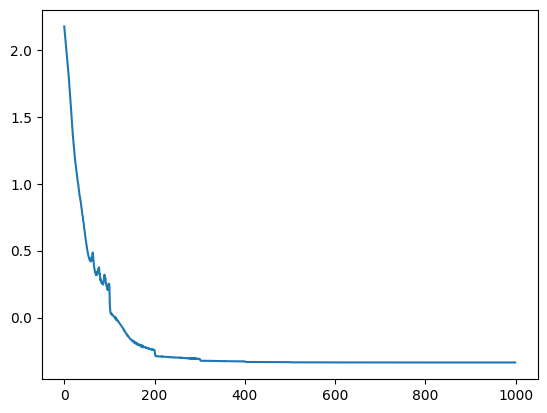

In [43]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [44]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.3107e-01, -1.7453e-01, -2.2937e-01, -1.2760e-01, -2.1371e-01,
         -2.1672e-01, -1.5113e-01, -1.4200e-01, -1.9592e-01, -1.4877e-01,
          1.7659e-06, -2.8031e-02, -3.4005e-07,  1.7647e-03, -6.2111e-07,
         -8.4044e-07,  2.7296e-07, -2.5196e-06, -1.5028e-06,  9.5722e-07,
         -2.7489e-06, -6.0168e-07,  2.2120e-06, -5.1610e-07,  1.8535e-06,
          1.0373e-06,  1.5337e-06,  1.6002e-06, -9.9164e-07, -2.1887e-07,
         -5.8477e-07,  1.5462e-06,  3.7897e-07, -2.6996e-06, -2.1803e-06,
         -1.1329e-07,  2.8269e-06,  7.2972e-07, -9.4831e-07,  7.8567e-07,
         -7.5241e-07,  2.3391e-06, -1.6082e-06, -3.6996e-06,  1.5571e-06,
         -3.1363e-06, -9.7858e-08, -4.7363e-07,  2.8135e-06,  6.6901e-08,
         -6.6957e-07, -7.2641e-07, -6.5962e-07, -1.8884e-06,  2.2605e-07,
          2.1343e-06,  1.4410e-06,  2.3526e-06, -1.1401e-06, -3.2419e-06,
          2.0990e-07,  4.2925e-07, -1.0811e-04,  5.3206e-07,  2.8012e-07,
          2.3880e-06,  3.3422e-06,  3.

tensor([[-1.3107e-01, -1.7453e-01, -2.2937e-01, -1.2760e-01, -2.1371e-01,
         -2.1672e-01, -1.5113e-01, -1.4200e-01, -1.9592e-01, -1.4877e-01,
          1.7659e-06, -2.8031e-02, -3.4005e-07,  1.7647e-03, -6.2111e-07,
         -8.4044e-07,  2.7296e-07, -2.5196e-06, -1.5028e-06,  9.5722e-07,
         -2.7489e-06, -6.0168e-07,  2.2120e-06, -5.1610e-07,  1.8535e-06,
          1.0373e-06,  1.5337e-06,  1.6002e-06, -9.9164e-07, -2.1887e-07,
         -5.8477e-07,  1.5462e-06,  3.7897e-07, -2.6996e-06, -2.1803e-06,
         -1.1329e-07,  2.8269e-06,  7.2972e-07, -9.4831e-07,  7.8567e-07,
         -7.5241e-07,  2.3391e-06, -1.6082e-06, -3.6996e-06,  1.5571e-06,
         -3.1363e-06, -9.7858e-08, -4.7363e-07,  2.8135e-06,  6.6901e-08,
         -6.6957e-07, -7.2641e-07, -6.5962e-07, -1.8884e-06,  2.2605e-07,
          2.1343e-06,  1.4410e-06,  2.3526e-06, -1.1401e-06, -3.2419e-06,
          2.0990e-07,  4.2925e-07, -1.0811e-04,  5.3206e-07,  2.8012e-07,
          2.3880e-06,  3.3422e-06,  3.

tensor([[-1.5839e-01, -2.0471e-01, -2.5401e-01, -1.8811e-01,  2.0555e-01,
         -2.7812e-01, -1.7494e-01, -1.6782e-01, -1.8947e-01, -2.0456e-01,
         -6.8986e-07,  3.8654e-04,  4.2125e-08,  3.8149e-02,  1.3451e-08,
         -1.6510e-07,  3.6052e-07, -6.5916e-07,  2.9866e-07, -4.9661e-08,
          7.9979e-10,  2.6343e-07, -1.2956e-07, -2.8231e-07,  1.1223e-06,
          1.3701e-07, -6.8273e-07, -7.5707e-07, -1.5767e-07,  1.0010e-07,
          7.3019e-08, -9.3322e-09,  7.5259e-08, -4.3867e-07,  4.1469e-07,
          5.5985e-07,  1.2883e-08,  2.3400e-09,  2.7206e-07, -3.6482e-07,
          5.3503e-08,  1.9103e-08, -5.8397e-08,  2.4908e-07,  2.6532e-07,
          1.6053e-07, -3.5241e-07, -3.1844e-08, -1.2323e-07, -4.2523e-08,
         -8.2357e-08, -2.3738e-07, -2.9854e-07, -7.7609e-08,  8.6319e-08,
         -2.9457e-07,  1.7023e-06,  3.0636e-07,  1.3994e-07,  3.9218e-08,
         -9.8766e-08,  7.4254e-09, -5.6743e-03, -3.4183e-08,  3.9682e-08,
         -1.6376e-07, -1.9929e-07,  1.

In [45]:

model_1(test_x1)[0].squeeze()
model_2(test_x2)[0].squeeze()
model_3(test_x3)[0].squeeze()


tensor([9.8123e-01, 9.8345e-01, 1.9098e-01, 6.2185e-01, 9.8395e-04, 9.8205e-01,
        9.3516e-01, 6.8034e-02, 9.7762e-01, 8.4899e-01, 8.7558e-06, 9.7873e-01,
        9.8744e-01, 1.5828e-02, 4.5704e-01, 9.7031e-01, 7.4809e-02, 9.2045e-01,
        1.7004e-02, 4.1311e-03, 3.5588e-03, 9.7367e-01, 9.5017e-01, 5.3322e-01,
        7.8223e-01, 2.3601e-01, 1.9466e-01, 1.9682e-02, 4.5533e-01, 3.1553e-01,
        1.7344e-01, 1.4292e-01, 1.0843e-03, 4.7685e-01, 1.6509e-01, 7.8427e-01,
        9.2975e-01, 9.4850e-01, 2.3037e-01, 5.7513e-04],
       grad_fn=<SqueezeBackward0>)

tensor([1.3012e-02, 9.9898e-01, 5.0417e-01, 5.1097e-01, 4.9810e-01, 9.9909e-01,
        5.6583e-01, 9.9045e-01, 5.5123e-02, 6.2419e-02, 6.4844e-03, 9.8922e-01,
        3.1355e-05, 9.8984e-01, 9.3813e-01, 3.6118e-02, 9.4036e-01, 9.2344e-01,
        5.5671e-03, 9.9960e-01, 7.8073e-02, 3.3817e-01, 1.8623e-02, 1.5380e-02,
        9.9628e-01, 6.2952e-04, 9.8031e-01, 2.7930e-03, 5.6016e-03, 9.9516e-01,
        9.9843e-01, 8.1843e-01, 7.2267e-02, 1.4681e-01, 9.8865e-01, 9.9782e-01,
        9.9974e-01, 3.4532e-01, 9.5551e-01, 9.5250e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0.4980, 0.9723, 0.9662, 0.9647, 0.0247, 0.2428, 0.6649, 0.1986, 0.9663,
        0.9461, 0.9247, 0.0673, 0.9777, 0.4397, 0.9767, 0.1043, 0.9782, 0.9622,
        0.9241, 0.9768, 0.7784, 0.4718, 0.8910, 0.8876, 0.1128, 0.0192, 0.0135,
        0.9724, 0.5758, 0.9659, 0.7763, 0.0047, 0.9016, 0.9230, 0.0222, 0.0859,
        0.4188, 0.8183, 0.5137, 0.1330], grad_fn=<SqueezeBackward0>)

In [46]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[45,  6],
       [11, 58]])

0.8405797101449275

0.8823529411764706

0.8583333333333333

0.90625

0.8721804511278196

In [47]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[17,  1],
       [ 5, 17]])

0.7727272727272727

0.9444444444444444

array([[13,  2],
       [ 5, 20]])

0.8

0.8666666666666667

array([[15,  3],
       [ 1, 21]])

0.9545454545454546

0.8333333333333334

In [49]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.31073713e-01, -1.74525872e-01, -2.29365438e-01,
        -1.27595946e-01, -2.13713899e-01, -2.16721699e-01,
        -1.51128590e-01, -1.41995043e-01, -1.95922837e-01,
        -1.48766443e-01,  1.76591061e-06, -2.80312207e-02,
        -3.40048672e-07,  1.76470017e-03, -6.21109223e-07,
        -8.40438304e-07,  2.72959170e-07, -2.51961001e-06,
        -1.50280755e-06,  9.57216116e-07, -2.74885383e-06,
        -6.01680938e-07,  2.21204277e-06, -5.16098112e-07,
         1.85354043e-06,  1.03733009e-06,  1.53367637e-06,
         1.60016168e-06, -9.91635147e-07, -2.18869275e-07,
        -5.84774000e-07,  1.54618147e-06,  3.78974846e-07,
        -2.69957377e-06, -2.18034415e-06, -1.13287200e-07,
         2.82689507e-06,  7.29715509e-07, -9.48310685e-07,
         7.85669215e-07, -7.52411154e-07,  2.33908008e-06,
        -1.60822867e-06, -3.69964209e-06,  1.55709552e-06,
        -3.13633882e-06, -9.78583685e-08, -4.73630593e-07,
         2.81350981e-06,  6.69014355e-08, -6.69567839e-0

array([[-1.31073713e-01, -1.74525872e-01, -2.29365438e-01,
        -1.27595946e-01, -2.13713899e-01, -2.16721699e-01,
        -1.51128590e-01, -1.41995043e-01, -1.95922837e-01,
        -1.48766443e-01,  1.76591061e-06, -2.80312207e-02,
        -3.40048672e-07,  1.76470017e-03, -6.21109223e-07,
        -8.40438304e-07,  2.72959170e-07, -2.51961001e-06,
        -1.50280755e-06,  9.57216116e-07, -2.74885383e-06,
        -6.01680938e-07,  2.21204277e-06, -5.16098112e-07,
         1.85354043e-06,  1.03733009e-06,  1.53367637e-06,
         1.60016168e-06, -9.91635147e-07, -2.18869275e-07,
        -5.84774000e-07,  1.54618147e-06,  3.78974846e-07,
        -2.69957377e-06, -2.18034415e-06, -1.13287200e-07,
         2.82689507e-06,  7.29715509e-07, -9.48310685e-07,
         7.85669215e-07, -7.52411154e-07,  2.33908008e-06,
        -1.60822867e-06, -3.69964209e-06,  1.55709552e-06,
        -3.13633882e-06, -9.78583685e-08, -4.73630593e-07,
         2.81350981e-06,  6.69014355e-08, -6.69567839e-0

array([[-1.31073713e-01, -1.74525872e-01, -2.29365438e-01,
        -1.27595946e-01, -2.13713899e-01, -2.16721699e-01,
        -1.51128590e-01, -1.41995043e-01, -1.95922837e-01,
        -1.48766443e-01,  1.76591061e-06, -2.80312207e-02,
        -3.40048672e-07,  1.76470017e-03, -6.21109223e-07,
        -8.40438304e-07,  2.72959170e-07, -2.51961001e-06,
        -1.50280755e-06,  9.57216116e-07, -2.74885383e-06,
        -6.01680938e-07,  2.21204277e-06, -5.16098112e-07,
         1.85354043e-06,  1.03733009e-06,  1.53367637e-06,
         1.60016168e-06, -9.91635147e-07, -2.18869275e-07,
        -5.84774000e-07,  1.54618147e-06,  3.78974846e-07,
        -2.69957377e-06, -2.18034415e-06, -1.13287200e-07,
         2.82689507e-06,  7.29715509e-07, -9.48310685e-07,
         7.85669215e-07, -7.52411154e-07,  2.33908008e-06,
        -1.60822867e-06, -3.69964209e-06,  1.55709552e-06,
        -3.13633882e-06, -9.78583685e-08, -4.73630593e-07,
         2.81350981e-06,  6.69014355e-08, -6.69567839e-0

In [50]:
threshold=0.1
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.13107371, -0.17452587, -0.22936544, -0.12759595, -0.2137139 ,
        -0.2167217 , -0.15112859, -0.14199504, -0.19592284, -0.14876644,
         0.        , -0.02803122,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 71])

12

In [51]:
TPR=[]
TNR=[]
accuracy=[]
precision=[]
f1=[]=[]
vsSEN=[]
vsSPE=[]
vsGM=[]
vsMR=[]
vsCCR=[]

In [52]:
index=np.nonzero(model_1_weight)[1]
beta=np.array(beta_1)
trueindex=np.where(beta!=0)[0]
trueindex=trueindex.tolist()
trueindex=set(trueindex)
TP=len(trueindex.intersection(index))
FP=len(np.setdiff1d(trueindex,index))
FN=len(trueindex)-TP
TN=p-len(trueindex)-FP
vsSEN=TP/(TP+FN)#vsSEN.
vsSPE=TN/(TN+FP)#vsSPE
vsSEN
vsSPE
math.sqrt(vsSEN*vsSPE)#vsGM
vsMR=(FP+FN)/(TP+FN+TN+FP)#vsMR
1-vsMR#vsCCR

1.0

0.9888888888888889

0.9944289260117533

0.99

(raylet) [2022-10-12 20:34:51,574 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1469726720; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:35:01,582 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1469562880; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:35:11,589 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1469480960; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:35:21,597 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1469362176; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 20:40:01,786 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1461764096; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:40:11,791 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1461116928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:40:21,796 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1460248576; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:40:31,800 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1459609600; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 20:45:11,932 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1439600640; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:45:21,936 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1439076352; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:45:31,943 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1438965760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:45:41,949 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1438855168; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 20:50:22,139 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1435062272; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:50:32,146 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1434976256; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:50:42,153 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1434873856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:50:52,160 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1434800128; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 20:55:32,348 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1431183360; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:55:42,355 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1431048192; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:55:52,362 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1430982656; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:56:02,368 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1430736896; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 21:00:42,569 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1427136512; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:00:52,576 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1427050496; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:01:02,583 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1426841600; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:01:12,590 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1426710528; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 21:05:52,813 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1423134720; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:06:02,821 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1422901248; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:06:12,828 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1422782464; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:06:22,835 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1422639104; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 21:11:03,029 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1418027008; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:11:13,036 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1417719808; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:11:23,043 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1417572352; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:11:33,050 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1417523200; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 21:16:34,855 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1469472768; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:16:44,861 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1469333504; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:16:54,868 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1469186048; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:17:04,874 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1469095936; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 21:49:33,178 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1445601280; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:49:43,199 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1445294080; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:49:53,210 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1444159488; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:50:03,233 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1443381248; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 21:54:43,684 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1419247616; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:54:53,692 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1419087872; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:55:03,698 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1418854400; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 21:55:13,704 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1418686464; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 21:59:53,901 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1427103744; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:00:03,909 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1426886656; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:00:13,916 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1426726912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:00:23,923 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1426472960; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 22:05:04,123 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1421721600; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:05:14,130 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1421537280; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:05:24,137 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1421357056; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:05:34,145 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1421262848; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 22:10:14,341 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1416298496; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:10:24,348 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1416114176; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:10:34,355 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1416007680; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:10:44,363 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1415839744; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 22:15:24,557 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1410441216; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:15:34,563 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1410306048; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:15:44,570 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1410150400; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:15:54,577 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1409966080; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 22:20:34,778 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1404653568; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:20:44,785 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1404465152; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:20:54,792 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1404268544; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:21:04,799 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1403985920; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 22:25:44,996 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1398689792; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:25:55,003 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1398493184; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:26:05,010 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1398239232; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:26:15,017 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1398022144; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 22:30:55,205 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1392758784; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:31:05,212 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1392488448; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:31:15,219 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1392295936; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:31:25,226 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1392082944; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 22:36:05,418 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1386790912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:36:15,473 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1386586112; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:36:25,487 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1386393600; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:36:35,494 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1386270720; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 22:41:15,688 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1380847616; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:41:25,694 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1380646912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:41:35,702 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1380524032; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:41:45,710 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1380372480; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 22:46:26,019 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1371090944; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:46:36,079 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1370681344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:46:46,092 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1369006080; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:46:56,112 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1367941120; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 22:51:36,634 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1339637760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:51:46,646 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1338953728; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:51:56,657 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1337544704; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:52:06,675 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1336815616; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 22:56:47,191 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1309433856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:56:57,196 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1307361280; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:57:07,213 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1306562560; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 22:57:17,218 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1305104384; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 23:01:57,713 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1277898752; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 23:02:07,719 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1276215296; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 23:02:17,732 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1275781120; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 23:02:27,741 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1274064896; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 23:07:08,193 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1246478336; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 23:07:18,199 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1245593600; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 23:07:28,212 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1243987968; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 23:07:38,232 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1243222016; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 23:12:18,729 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1215447040; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 23:12:28,747 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1214558208; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 23:12:38,754 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1212817408; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 23:12:48,769 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1212362752; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 23:17:29,221 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1184382976; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 23:17:39,238 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1183563776; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 23:17:49,243 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1182621696; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 23:17:59,252 E 29773 29791] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-09-38_653656_3891 is over 95% full, available space: 1180897280; capacity: 29394726912. Object creation will fail i